# Predict Customer Purchase Behavior
Dataset: https://www.kaggle.com/datasets/rabieelkharoua/predict-customer-purchase-behavior-dataset

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import pickle

%matplotlib inline

### A. Data preparation and data cleaning
* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [200]:
data_path = './customer_purchase_data.csv'
df = pd.read_csv(data_path)

In [201]:
data_info = df.info()
data_head = df.head()
data_missing = df.isnull().sum()
data_describe = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1500 non-null   int64  
 1   Gender              1500 non-null   int64  
 2   AnnualIncome        1500 non-null   float64
 3   NumberOfPurchases   1500 non-null   int64  
 4   ProductCategory     1500 non-null   int64  
 5   TimeSpentOnWebsite  1500 non-null   float64
 6   LoyaltyProgram      1500 non-null   int64  
 7   DiscountsAvailed    1500 non-null   int64  
 8   PurchaseStatus      1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB


In [245]:
df.max()

age                              70
gender                         male
annualincome          149785.176481
numberofpurchases                20
productcategory              sports
timespentonwebsite        59.991105
loyaltyprogram                  yes
discountsavailed                  5
purchasestatus                  yes
dtype: object

In [202]:
df.columns = df.columns.str.lower()

In [203]:
df.columns

Index(['age', 'gender', 'annualincome', 'numberofpurchases', 'productcategory',
       'timespentonwebsite', 'loyaltyprogram', 'discountsavailed',
       'purchasestatus'],
      dtype='object')

In [204]:
df.head()

,age,gender,annualincome,numberofpurchases,productcategory,timespentonwebsite,loyaltyprogram,discountsavailed,purchasestatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


#### Distinguish between numerical features and categorical features

In [205]:
categorical_features = ['gender', 'productcategory', 'loyaltyprogram', 'purchasestatus']
numerical_features = [col for col in df.columns if col not in categorical_features]

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'annualincome', 'numberofpurchases', 'timespentonwebsite', 'discountsavailed']
Categorical features: ['gender', 'productcategory', 'loyaltyprogram', 'purchasestatus']


In [206]:
gender_values = {
    0: 'male',
    1: 'female'
}

df.gender = df.gender.map(gender_values)

productcategory_values = {
    0: 'electronics', 
    1: 'clothing',
    2: 'homegoods',
    3: "beauty",
    4: "sports"
}

df.productcategory = df.productcategory.map(productcategory_values)


loyaltyprogram_values = {
    0: 'no',
    1: 'yes'
}

df.loyaltyprogram = df.loyaltyprogram.map(loyaltyprogram_values)


purchasestatus_values = {
    0: 'no',
    1: 'yes'
}

df.purchasestatus = df.purchasestatus.map(purchasestatus_values)

### B. EDA, feature importance analysis

In [207]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

age
[40 20 27 24 31]
53

gender
['female' 'male']
2

annualincome
[ 66120.26793868  23579.77358303 127821.30643165 137798.62311955
  99300.96422033]
1388

numberofpurchases
[ 8  4 11 19 14]
21

productcategory
['electronics' 'homegoods' 'beauty' 'clothing' 'sports']
5

timespentonwebsite
[30.56860116 38.24009661 31.6332115  46.16705881 19.82359186]
1388

loyaltyprogram
['no' 'yes']
2

discountsavailed
[5 0 4 2 3]
6

purchasestatus
['yes' 'no']
2



#### Conduct preliminary analysis of numerical features

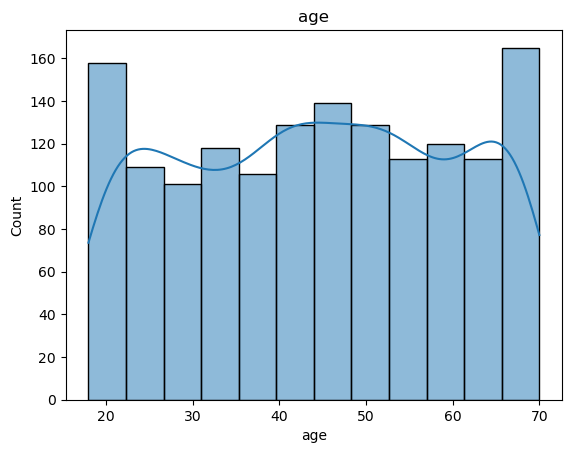

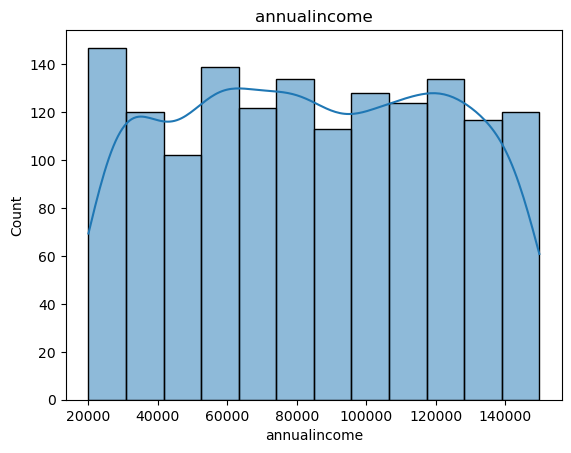

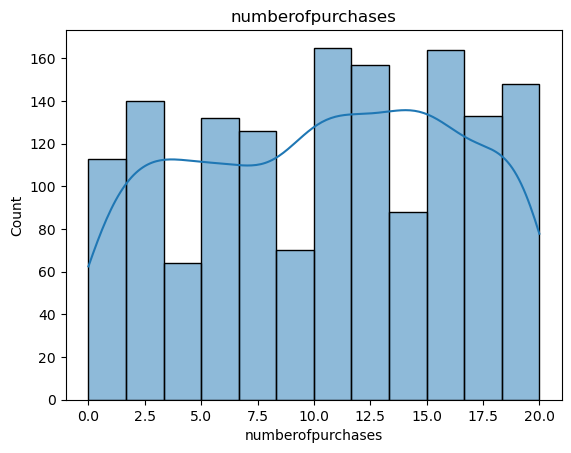

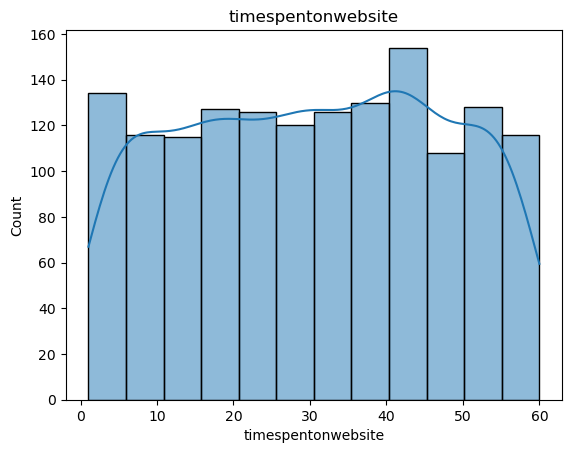

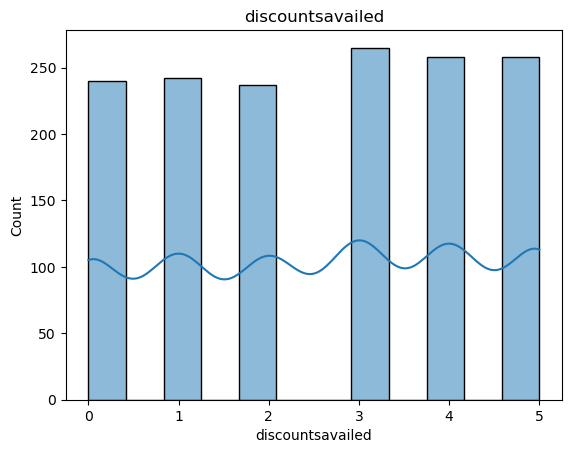

In [208]:
# Draw a histogram and add the kernel density estimation curve (KDE Curve)
for col in numerical_features:
    sns.histplot(df[col], kde=True) # Draw a histogram, use KDE to smooth data distribution
    plt.title(col)
    plt.show()


Column: gender, Unique values: 2


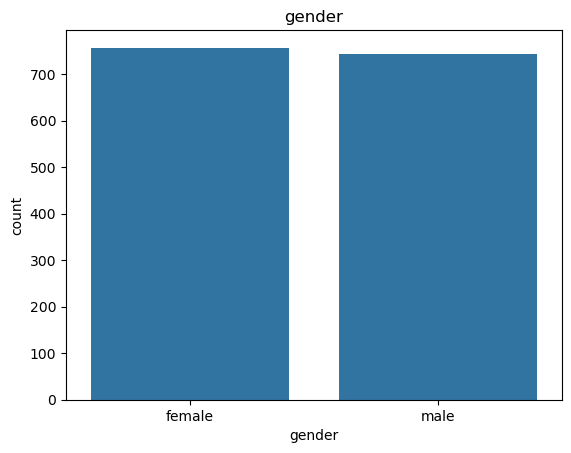

Column: productcategory, Unique values: 5


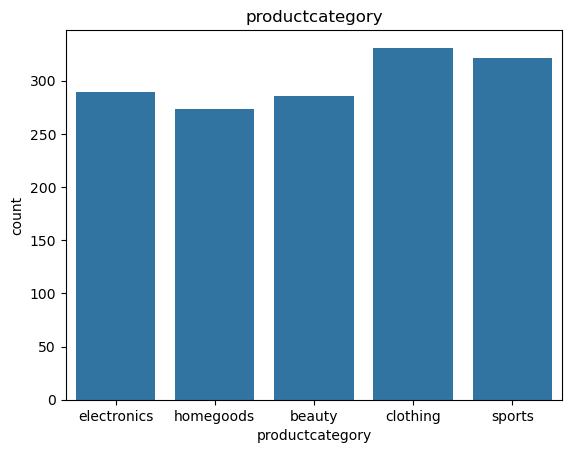

Column: loyaltyprogram, Unique values: 2


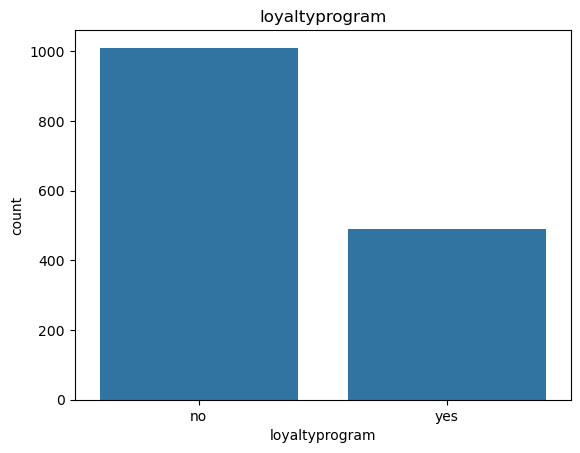

Column: purchasestatus, Unique values: 2


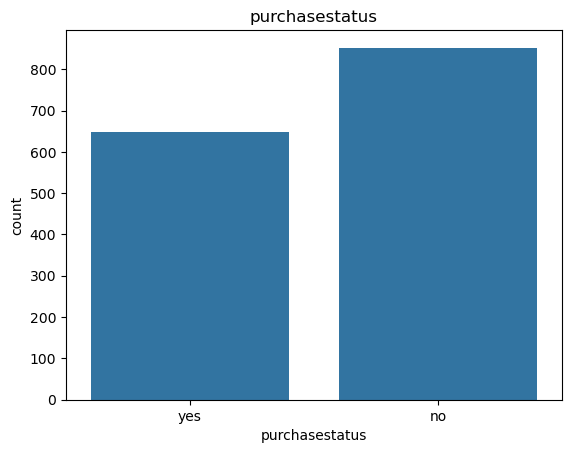

In [209]:
for col in categorical_features:
    print(f'Column: {col}, Unique values: {df[col].nunique()}')
    sns.countplot(x=col, data=df)
    plt.title(col)
    plt.show()

#### Setting up the Validation Framework

In [210]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [211]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [212]:
y_train = (df_train.purchasestatus == 'yes').astype('int').values
y_val = (df_val.purchasestatus == 'yes').astype('int').values
y_test = (df_test.purchasestatus == 'yes').astype('int').values

In [213]:
del df_train['purchasestatus']
del df_val['purchasestatus']
del df_test['purchasestatus']

In [214]:
df_train

,age,gender,annualincome,numberofpurchases,productcategory,timespentonwebsite,loyaltyprogram,discountsavailed
0,47,female,125446.090091,4,electronics,16.096480,no,5
1,43,female,114767.538015,12,homegoods,50.409603,no,2
2,39,male,115006.725447,9,homegoods,2.665497,yes,1
3,64,female,132261.177927,13,beauty,35.305783,no,1
4,58,female,143569.036836,20,clothing,53.436044,no,4
...,...,...,...,...,...,...,...,...
895,32,male,80002.471675,9,homegoods,41.153079,no,2
896,66,male,127577.459874,14,sports,26.180632,no,5
897,62,male,147857.791453,5,electronics,20.083128,yes,4
898,55,female,102467.279553,4,beauty,26.881399,yes,4


#### feature importance analysis

In [215]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [216]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

dv = DictVectorizer(sparse=False)
X_val = dv.fit_transform(val_dicts)

In [217]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [218]:
importances = dt.feature_importances_
feature_names = dv.feature_names_

feature_importance = list(zip(feature_names, importances))
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

sorted_importance


[('annualincome', 0.19401319156556798),
 ('discountsavailed', 0.17162895782718754),
 ('numberofpurchases', 0.15985976870091798),
 ('age', 0.1543269071224991),
 ('timespentonwebsite', 0.14466390283168032),
 ('loyaltyprogram=no', 0.08634261377331402),
 ('loyaltyprogram=yes', 0.06556654335418949),
 ('productcategory=sports', 0.01283640004220702),
 ('productcategory=electronics', 0.004355291275133103),
 ('gender=female', 0.0033916359744546997),
 ('gender=male', 0.0030147875328486217),
 ('productcategory=beauty', 0.0),
 ('productcategory=clothing', 0.0),
 ('productcategory=homegoods', 0.0)]

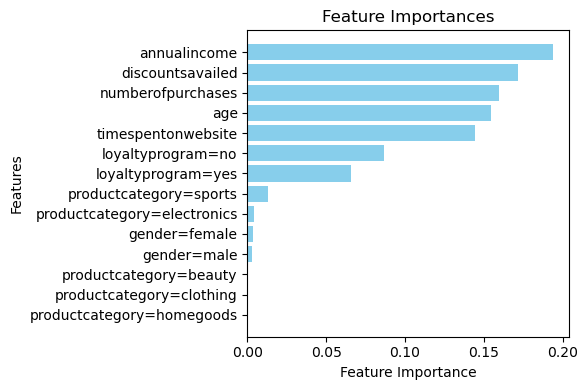

In [219]:

features = [x[0] for x in sorted_importance]
importances = [x[1] for x in sorted_importance]

plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### C. Model selection process and parameter tuning

### C-1. Decision Tree Model

#### selected features

In [220]:
selected_features = [name for name, importance in feature_importance if importance > 0.05]

print(selected_features)

selected_indices = [feature_names.index(name) for name in selected_features]

X_train_selected = X_train[:, selected_indices]
X_val_selected = X_val[:, selected_indices]

['age', 'annualincome', 'discountsavailed', 'loyaltyprogram=no', 'loyaltyprogram=yes', 'numberofpurchases', 'timespentonwebsite']


#### Parameter Tuning

In [221]:
# max_depth

depths = [1,2,3,4,5,6,10,15,20, None]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train_selected, y_train)
    
    y_pred_val = dt.predict_proba(X_val_selected)[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    
    print(f'Depth {depth}: Validation AUC = {auc_val:.3f}')
    

Depth 1: Validation AUC = 0.673
Depth 2: Validation AUC = 0.748
Depth 3: Validation AUC = 0.823
Depth 4: Validation AUC = 0.898
Depth 5: Validation AUC = 0.924
Depth 6: Validation AUC = 0.872
Depth 10: Validation AUC = 0.835
Depth 15: Validation AUC = 0.834
Depth 20: Validation AUC = 0.834
Depth None: Validation AUC = 0.834


In [222]:
# min_samples_leaf
scores = []

for depth in [4,5,6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train_selected, y_train)
        
        y_pred = dt.predict_proba(X_val_selected)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [223]:
columns = ['max_depth', 'min_sample_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index = 'min_sample_leaf', columns='max_depth', values = 'auc')
df_scores_pivot.round(3)

max_depth,4,5,6
min_sample_leaf,,,
1,0.898,0.926,0.894
5,0.898,0.904,0.902
10,0.898,0.924,0.923
15,0.893,0.913,0.915
20,0.895,0.895,0.899
100,0.807,0.807,0.807
200,0.762,0.762,0.762
500,0.500,0.500,0.500


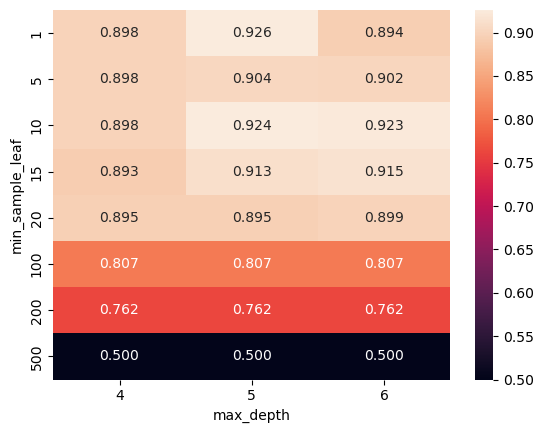

In [224]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")
plt.show()

In [225]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train_selected, y_train)

print(export_text(dt, feature_names=selected_features))

|--- timespentonwebsite <= 30.00
|   |--- age <= 39.50
|   |   |--- numberofpurchases <= 5.50
|   |   |   |--- discountsavailed <= 2.50
|   |   |   |   |--- numberofpurchases <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- numberofpurchases >  1.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- discountsavailed >  2.50
|   |   |   |   |--- class: 0
|   |   |--- numberofpurchases >  5.50
|   |   |   |--- discountsavailed <= 2.50
|   |   |   |   |--- loyaltyprogram=no <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- loyaltyprogram=no >  0.50
|   |   |   |   |   |--- timespentonwebsite <= 17.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- timespentonwebsite >  17.01
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- discountsavailed >  2.50
|   |   |   |   |--- annualincome <= 54259.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- annualincome >  54259.07
|   |   |   |   |   |--- timespentonwebsite <= 7.38
|   |   |   |   |  

### C-2. Random Forest Model

In [226]:
scores = []

for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train_selected, y_train)
    
    y_pred = rf.predict_proba(X_val_selected)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [227]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.928805
1,20,0.926969
2,30,0.934086
3,40,0.933701
4,50,0.932205
5,60,0.933587
6,70,0.934086
7,80,0.934222
8,90,0.933542
9,100,0.934381


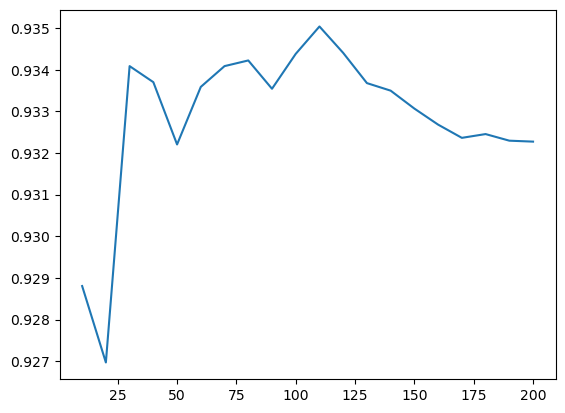

In [228]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.show()

In [229]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train_selected, y_train)
        
        y_pred = rf.predict_proba(X_val_selected)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, n, auc))

In [230]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,max_depth,n_estimators,auc
0,5,10,0.918627
1,5,20,0.915273
2,5,30,0.922005
3,5,40,0.921642
4,5,50,0.923501
5,5,60,0.925835
6,5,70,0.928102
7,5,80,0.926334
8,5,90,0.926062
9,5,100,0.925337


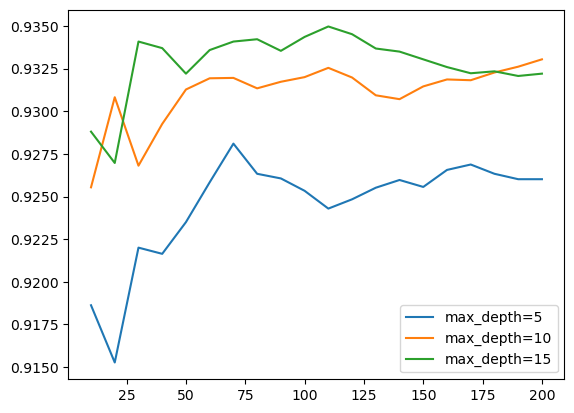

In [231]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)
    
plt.legend()
plt.show()

In [232]:
max_depth = 15

In [233]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=42)
        rf.fit(X_train_selected, y_train)
        
        y_pred = rf.predict_proba(X_val_selected)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((s, n, auc))

In [234]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores

,min_samples_leaf,n_estimators,auc
0,1,10,0.928805
1,1,20,0.926969
2,1,30,0.934086
3,1,40,0.933701
4,1,50,0.932205
...,...,...,...
95,50,160,0.917857
96,50,170,0.917267
97,50,180,0.916950
98,50,190,0.917449


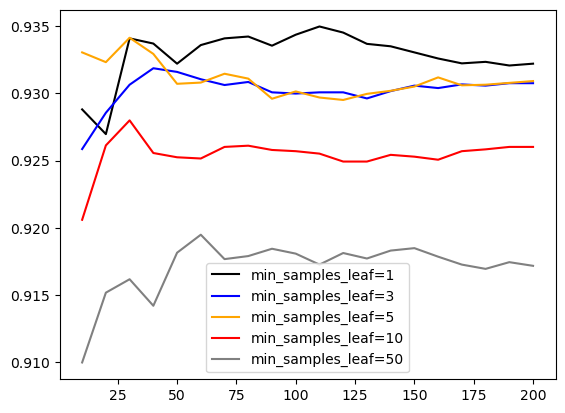

In [235]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label='min_samples_leaf=%d' % s)
    
plt.legend()
plt.show()

In [236]:
params = {
    'n_estimators': [100, 110, 120],
    'max_depth': [max_depth],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=rf, param_grid=params, scoring='roc_auc', cv=3, verbose=2)
grid_search.fit(X_train_selected, y_train)

best_rf = grid_search.best_estimator_


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=100; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=110; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=110; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=110; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=120; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=120; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=120; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=3, n_estimators=100; total time=   0.1s
[CV] END .max_depth=15, min_samples_leaf=3, n_est

In [237]:
print("Best rf: ", best_rf)

Best rf:  RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=110,
                       random_state=42)


In [238]:
rf = RandomForestClassifier(n_estimators=110, max_depth=15, min_samples_leaf=5, random_state=42)
rf.fit(X_train_selected, y_train)

y_pred = rf.predict_proba(X_val_selected)[:, 1]
rf_val_auc = roc_auc_score(y_val, y_pred)

print("RF Val AUC: ", rf_val_auc)

RF Val AUC:  0.9296885624915001


#### Select the final model

In [239]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train_selected, y_train)

y_pred = dt.predict_proba(X_val_selected)[:, 1]
dt_auc= roc_auc_score(y_val, y_pred)

print("Decision_Tree AUC: ", dt_auc)

Decision_Tree AUC:  0.916904664762682


In [240]:
rf = RandomForestClassifier(n_estimators=110, max_depth=15, min_samples_leaf=5, random_state=42)
rf.fit(X_train_selected, y_train)

y_pred = rf.predict_proba(X_val_selected)[:, 1]
rf_val_auc = roc_auc_score(y_val, y_pred)

print("Random_Forest AUC: ", rf_val_auc)

Random_Forest AUC:  0.9296885624915001
